In [59]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random 
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
import pandas as pd 
import yaml 
import matplotlib.pyplot as plt; plt.ion()
from matplotlib import rc, rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from lenspack.utils import bin2d
from lenspack.image.inversion import ks93
from lenspack.peaks import find_peaks2d

from SMPy import utils, utilsv2
from SMPy.KaiserSquires import kaiser_squires, plot_kmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
def read_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

config = read_config("./config_Abell3411.yaml")
center_cl = {"ra_center": 130.477917, "dec_center": -17.484722}

In [61]:
def load_shear_data(shear_cat_path, ra_col, dec_col, g1_col, g2_col, weight_col, x_col, y_col):
    """ 
    Load shear data from a FITS file and return a pandas DataFrame.

    :param path: Path to the FITS file.
    :param ra_col: Column name for right ascension.
    :param dec_col: Column name for declination.
    :param g1_col: Column name for the first shear component.
    :param g2_col: Column name for the second shear component.
    :param weight_col: Column name for the weight.
    :return: pandas DataFrame with the specified columns.
    """
    # Read data from the FITS file
    shear_catalog = Table.read(shear_cat_path)

    # Convert to pandas DataFrame
    shear_df = pd.DataFrame({
        'ra': shear_catalog[ra_col],
        'dec': shear_catalog[dec_col],
        'g1': shear_catalog[g1_col],
        'g2': shear_catalog[g2_col],
        'weight': shear_catalog[weight_col],
        'x': shear_catalog[x_col],
        'y': shear_catalog[y_col],
    })
    
    return shear_df

In [62]:
# Finally, computing the oringinal kappa map
shear_df = load_shear_data(config['input_path'], 
                                          config['ra_col'], 
                                          config['dec_col'], 
                                          config['g1_col'], 
                                          config['g2_col'],
                                          config['weight_col'],
                                          config['x_col'],
                                          config['y_col'])

In [63]:
true_boundaries = utils.calculate_field_boundaries_v2(shear_df['ra'], shear_df['dec'])
shear_df, ra_0, dec_0 = utils.correct_RA_dec(shear_df)
boundaries = utils.calculate_field_boundaries_v2(shear_df['ra'], shear_df['dec'])
boundaries_xy = utils.calculate_field_boundaries_v2(shear_df['x'], shear_df['y'])

In [64]:
# correct the cluster center
def correct_center(center_cl):
    center_c = {}
    center_c["ra_center"] = (center_cl["ra_center"] - ra_0) * np.cos(np.deg2rad(center_cl["dec_center"]))
    center_c["dec_center"] = center_cl["dec_center"] - dec_0
    return center_c

center_cl = correct_center(center_cl)

Text(0.5, 1.0, 'y vs dec')

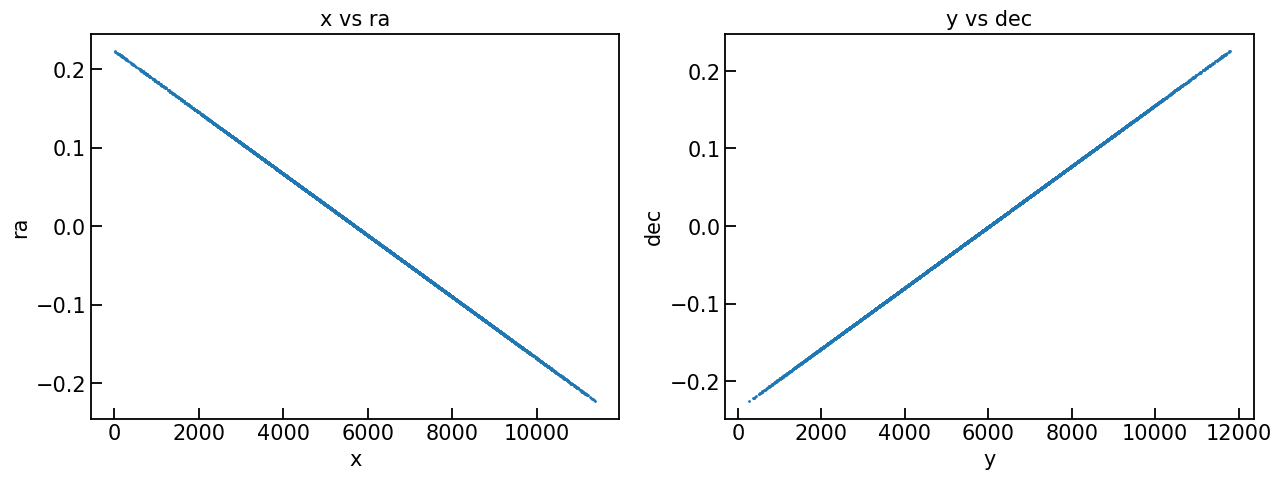

In [65]:
# Plot x vs ra and y_vs_dec
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(shear_df['x'], shear_df['ra'], s=1)
plt.xlabel('x')
plt.ylabel('ra')
plt.title('x vs ra')
plt.subplot(1, 2, 2)
plt.scatter(shear_df['y'], shear_df['dec'], s=1)
plt.xlabel('y')
plt.ylabel('dec')
plt.title('y vs dec')   

In [66]:
aspect_ratio = (boundaries['ra_max'] - boundaries['ra_min']) / (boundaries['dec_max'] - boundaries['dec_min'])
pix_ra = 100
pix_dec = int(pix_ra / aspect_ratio)

g1map_og_1, g2map_og_1 = utils.create_shear_grid_v2(shear_df['ra'], shear_df['dec'], shear_df['g1'], shear_df['g2'], config["resolution"], shear_df['weight'])

og_kappa_e_1, og_kappa_b_1 = kaiser_squires.ks_inversion(g1map_og_1, -g2map_og_1)

x_factor, y_factor = (np.max(shear_df['x']) - np.min(shear_df['x']))/ (np.max(shear_df['ra']) - np.min(shear_df['ra'])), (np.max(shear_df['y']) - np.min(shear_df['y']))/ (np.max(shear_df['dec']) - np.min(shear_df['dec']))

factor = (x_factor + y_factor) / 2
resolution_xy = int(config["resolution"] * factor)

g1map_og_2, g2map_og_2 = utils.create_shear_grid_v2(shear_df['x'], shear_df['y'], shear_df['g1'], shear_df['g2'], resolution_xy, shear_df['weight'])

og_kappa_e_2, og_kappa_b_2 = kaiser_squires.ks_inversion(g1map_og_2, g2map_og_2)


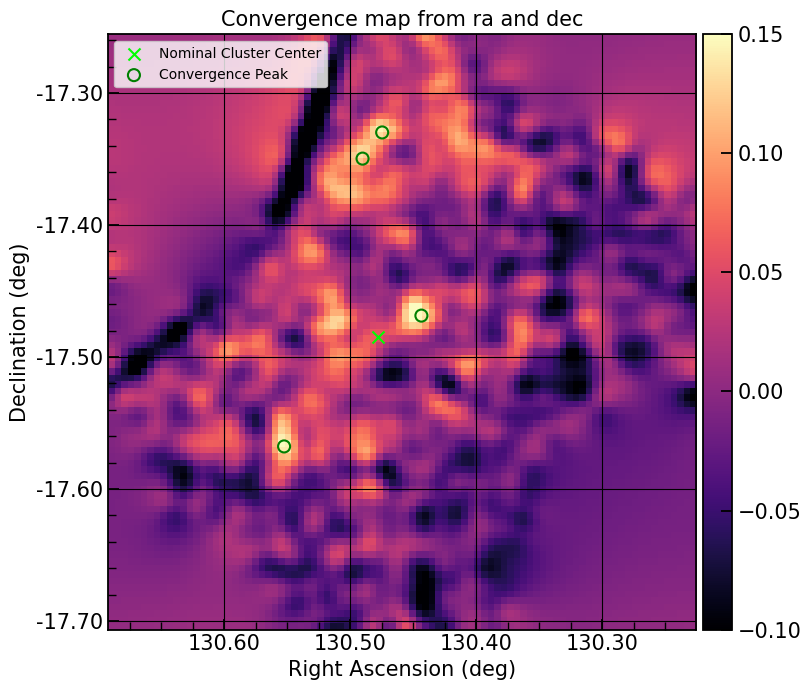

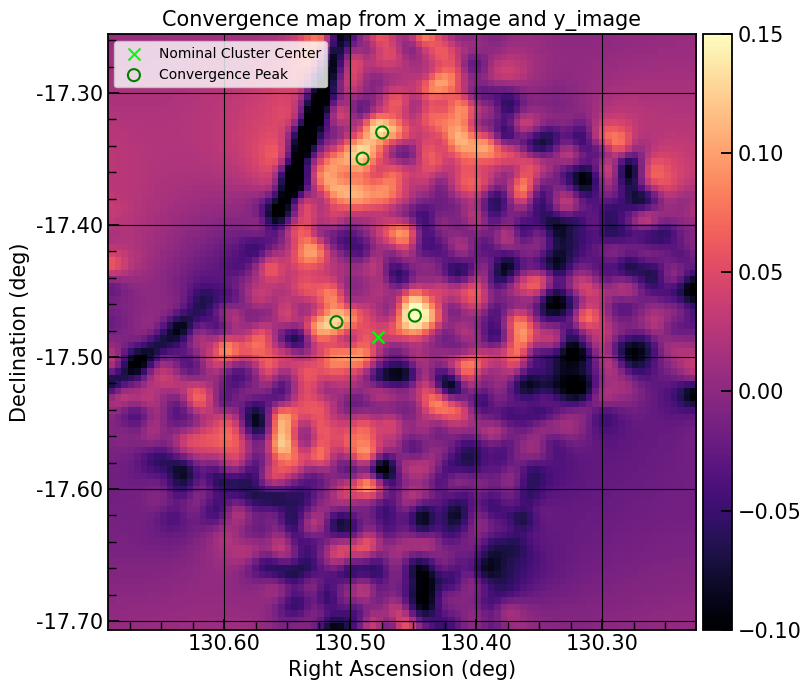

[42 63 48 51] [43 48 51 55]


In [67]:
cn1 = plot_kmap.plot_convergence_v4(og_kappa_e_1, boundaries, true_boundaries, config, center_cl=center_cl, vmax=0.15, vmin=-0.10, smoothing=1.5, title="Convergence map from ra and dec",threshold=0.13)
cn2 = plot_kmap.plot_convergence_v4(og_kappa_e_2, boundaries, true_boundaries, config, center_cl=center_cl, invert_map=False, vmax=0.15, vmin=-0.10, smoothing=1.5, title="Convergence map from x_image and y_image", threshold=0.13)

print(cn1, cn2)

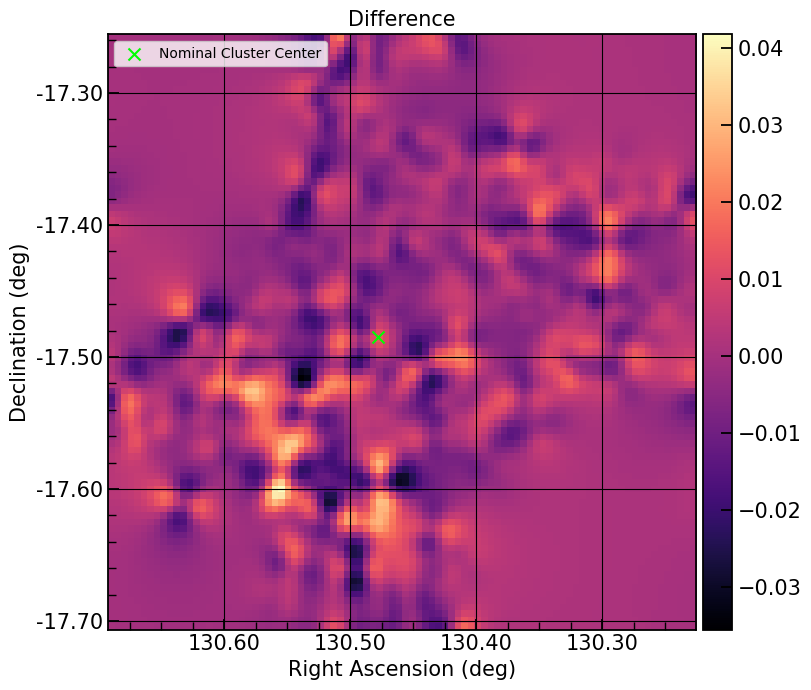

[]

In [68]:
plot_kmap.plot_convergence_v4(og_kappa_e_1-og_kappa_e_2[:,::-1], boundaries, true_boundaries, config, center_cl=center_cl, smoothing=1.5, title="Difference")


In [11]:
shuffled_dfs = utils.generate_multiple_shear_dfs(shear_df, 1000, seed=42)
#shuffled_dfs = utilsv2.generate_multiple_shear_dfs(shear_df, 1000, seed=42)

In [12]:
g1_g2_map_list_ra_dec = utils.shear_grids_for_shuffled_dfs(shuffled_dfs, config)
g1_g2_map_list_xy = utils.shear_grids_for_shuffled_dfs_xy(shuffled_dfs, resolution_xy)

In [13]:
shuff_kappa_e_list_rd, shuff_kappa_b_list_rd = utils.ks_inversion_list(g1_g2_map_list_ra_dec, 'ra_dec')
shuff_kappa_e_list_xy, shuff_kappa_b_list_xy = utils.ks_inversion_list(g1_g2_map_list_xy, 'xy')

In [14]:
kappa_e_stack = np.stack(shuff_kappa_e_list_rd, axis = 0)
kappa_e_stack_smoothed = np.zeros_like(kappa_e_stack)
kernel = 1.5
for i in range(kappa_e_stack.shape[0]):
    kappa_e_stack_smoothed[i] = gaussian_filter(kappa_e_stack[i], kernel)
    
kappa_e_stack_xy = np.stack(shuff_kappa_e_list_xy, axis = 0)
kappa_e_stack_smoothed_xy = np.zeros_like(kappa_e_stack_xy)
for i in range(kappa_e_stack_xy.shape[0]):
    kappa_e_stack_smoothed_xy[i] = gaussian_filter(kappa_e_stack_xy[i], kernel)

In [15]:
std_rd = np.std(kappa_e_stack_smoothed, axis=0)
std_xy = np.std(kappa_e_stack_smoothed_xy, axis=0)

In [24]:
center_cl = {"ra_center": 130.4488, "dec_center": -17.4795}
center_cl = correct_center(center_cl)

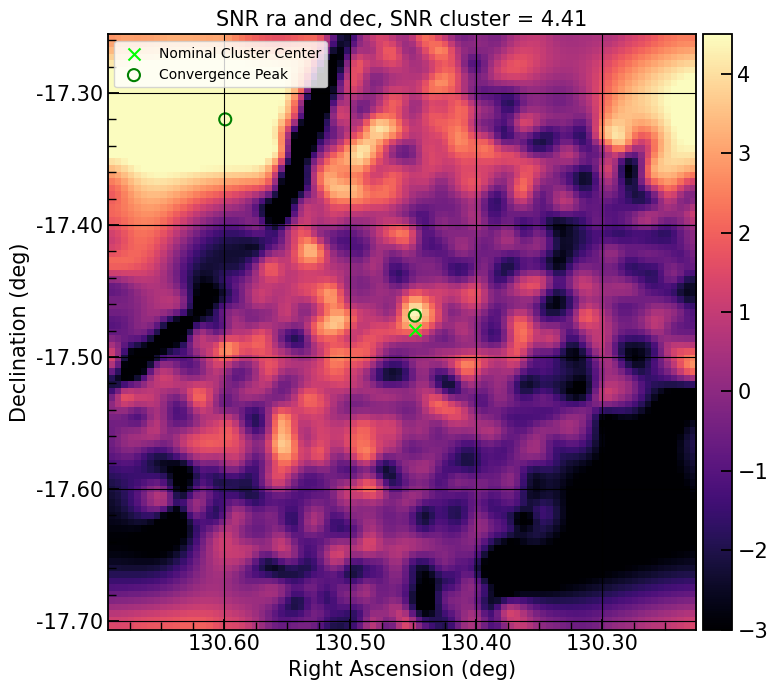

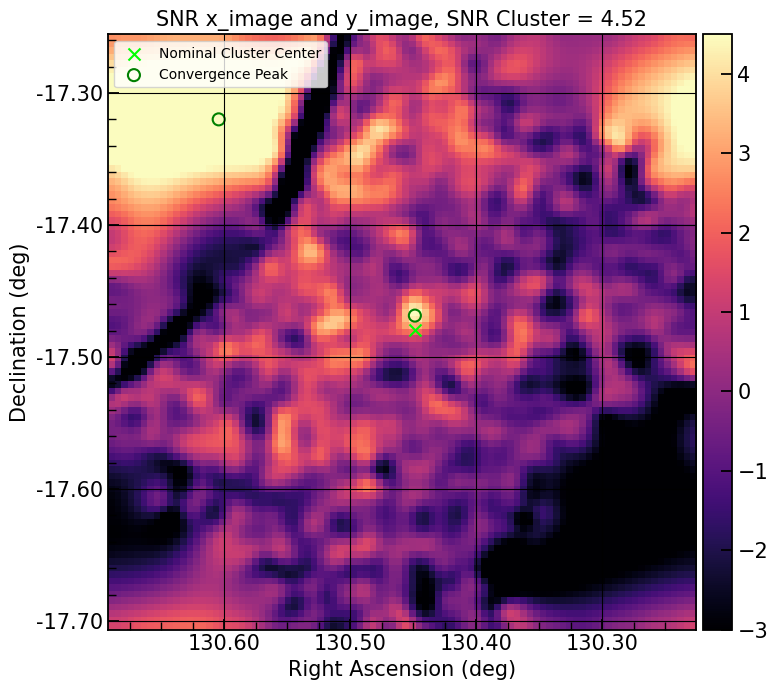

[72 43] [73 43]


In [58]:
# SNR Plots

snr1 = plot_kmap.plot_convergence_v4(gaussian_filter(og_kappa_e_1, kernel)/std_rd, boundaries, true_boundaries, config, center_cl=center_cl, title="SNR ra and dec, SNR cluster = 4.41", threshold=4.4, vmax=4.5, vmin=-3.)

snr2 = plot_kmap.plot_convergence_v4(gaussian_filter(og_kappa_e_2, kernel)/std_xy, boundaries, true_boundaries, config, center_cl=center_cl, invert_map=False, title="SNR x_image and y_image, SNR Cluster = 4.52", threshold=4.4, vmax=4.5, vmin=-3.)

print(snr1, snr2)


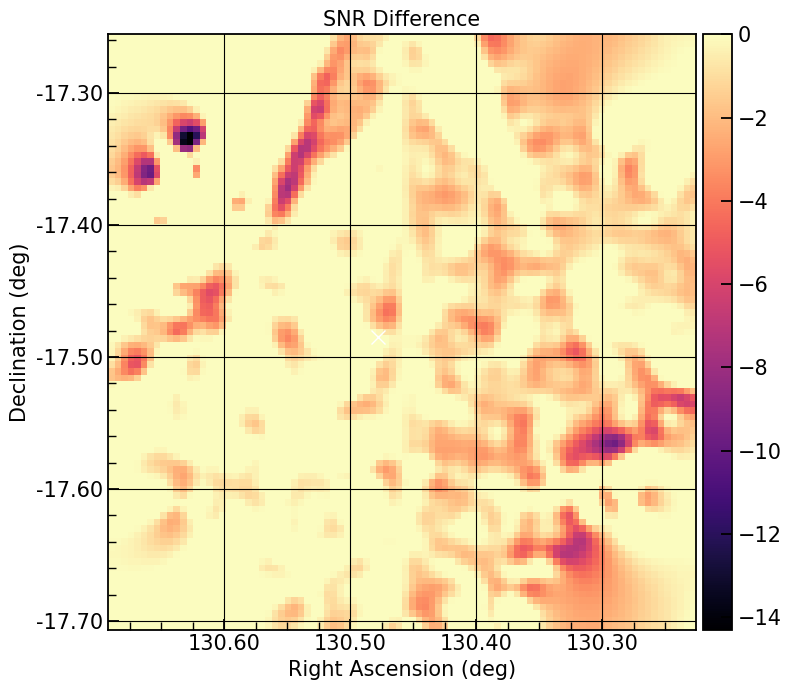

[]

In [18]:
# SNR Difference
plot_kmap.plot_convergence_v4( gaussian_filter(og_kappa_e_1, kernel)/std_rd - gaussian_filter(og_kappa_e_2, kernel)/std_xy[:,::-1], boundaries, true_boundaries, config, center_cl=center_cl, title="SNR Difference", vmax=0)

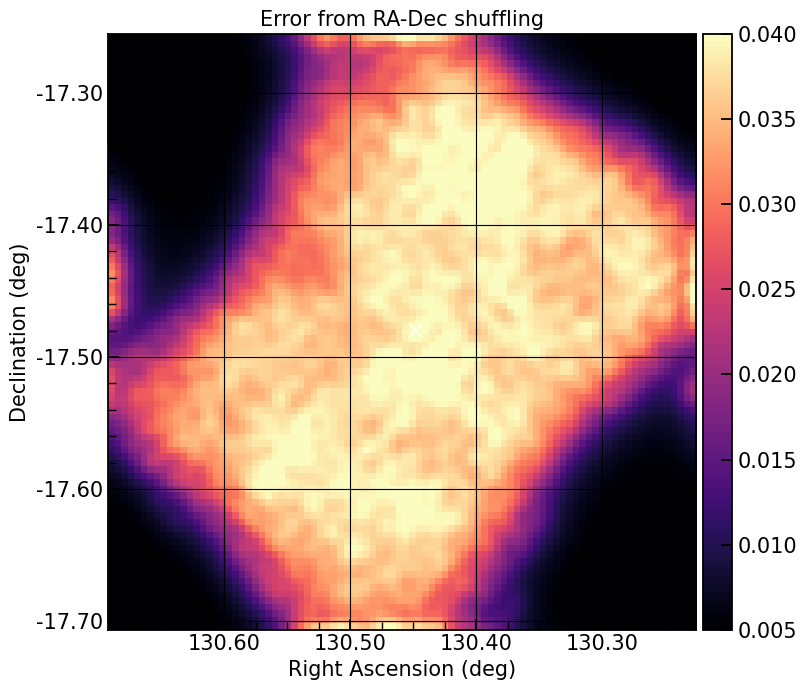

[]

In [25]:
# SNR Difference
plot_kmap.plot_convergence_v4(std_xy, boundaries, true_boundaries, config, center_cl=center_cl, invert_map=False, title="Error from RA-Dec shuffling", vmax=0.04, vmin=0.005)